In [1]:
import numpy as np
from MLmodel_F8 import MLModel
from SageFunctions_F8 import SageFunctions, set_seed

In [2]:
set_seed(1337)

In [3]:
from SageFunctions_F8 import list2vertices

test_vertices_list = [1, 5, 2, 7, 3, 1, 3, 6, 4, 1, 4, 2, 4, 5, 5, 1]

# convert list with vertices coordinates into a list of vertices
test_vertices = list2vertices(test_vertices_list)
print(test_vertices)

prime = 8
SF = SageFunctions(prime)

generator = SF.vertices2GeneratorObj(test_vertices)
print(generator)

generator_numpy = SF.vertices2GeneratorMatrix(test_vertices)
print(generator_numpy)

minimum_distance = SF.vertices2mindist(test_vertices)
print(minimum_distance)

[(1, 5), (2, 7), (3, 1), (3, 6), (4, 1), (4, 2), (4, 5), (5, 1)]
[            1             0             0             0             0             1      z3^2 + 1             0             0      z3^2 + 1             0      z3^2 + 1          z3^2     z3^2 + z3             0            z3          z3^2            z3      z3^2 + 1          z3^2     z3^2 + z3 z3^2 + z3 + 1        z3 + 1             1            z3          z3^2             0          z3^2            z3             1             1             1            z3     z3^2 + z3     z3^2 + z3        z3 + 1             0     z3^2 + z3        z3 + 1             0             0            z3 z3^2 + z3 + 1             0 z3^2 + z3 + 1            z3     z3^2 + z3 z3^2 + z3 + 1      z3^2 + 1]
[            0             1             0             0             0      z3^2 + 1     z3^2 + z3             0             0          z3^2             1             1     z3^2 + z3             1             0 z3^2 + z3 + 1             0     z3^2

In [ ]:
# Transformer ML Model parameters
PATH = "transformer_436_vector_post_train_best.pt"
args = None

# Initialize class which provides access to model
model = MLModel(PATH, model_type="Transformer_v43")

In [6]:
mindist = model.predict(generator_numpy)
print(mindist)

30.848797


In [ ]:
import pygad

from GAPopulationFuncs_F8 import generateInitialPopulation, mutation_func, crossover_func, population2populationVertices, reduce_population

def mutation_wrapper(offspring_, ga_instance_):
   return mutation_func(SF, offspring_, ga_instance_)

# non need to use @parallel decorator since we are dealing with one fixed number of vertices each time
# generator with lstm model
def generator(num_vertices, target_dimension):
    
    # Initialize genetic algorithm class

    # public parameters
    num_generations = 200
    num_parents_mating = 200
    sol_per_pop = 300 # Number of solutions in the population.
    parent_selection_type = "sus" #  The parent selection type:
                                  # sss (for steady-state selection),
                                  # rws (for roulette wheel selection),
                                  # sus (for stochastic universal selection),
                                  # rank (for rank selection),
                                  # random (for random selection),
                                  # tournament (for tournament selection)
    keep_elitism = 30 # number of elitism (i.e. best solutions) to keep in the next generation

    # private parameters
    num_genes = 2 * num_vertices
    init_range_low = 0
    init_range_high = prime - 2
    gene_space = np.arange(init_range_low, init_range_high + 1) # +1 because range upper bound not inclusive
    initial_population = generateInitialPopulation(SF, sol_per_pop, num_genes)

    # Transformer ML model
    PATH = "transformer_436_vector_post_train_best.pt"

    # Initialize class which provides access to model
    model = MLModel(PATH, model_type="Transformer_v43")

    # need to redefine the fitness function
    offset = 300.
    def fitness_func(ga_instance, vertices_list, solution_idx):
        '''should receive "The instance of the pygad.GA class", "solution", "The indices of the solutions in the population"'''
        toric_Generator = SF.vertices2GeneratorMatrix(SF.list2vertices(vertices_list))
        dim = toric_Generator.shape[0]
        mindist = model.predict(toric_Generator)
        return offset + mindist - abs(dim - target_dimension) * 10

    ga_instance = pygad.GA(num_generations=num_generations,
                          num_parents_mating=num_parents_mating,
                          fitness_func=fitness_func,
                          gene_type=int,
                          sol_per_pop=sol_per_pop,
                          num_genes=num_genes,
                          initial_population = initial_population,
                          gene_space = gene_space,
                          parent_selection_type=parent_selection_type,
                          keep_elitism = keep_elitism,
                          mutation_type=mutation_wrapper,
                          mutation_percent_genes=15,
                          crossover_type=crossover_func
                          )
    ga_instance.run()
    ga_instance.plot_fitness()

    best_solution, best_solution_fitness, solution_idx = ga_instance.best_solution()
    print("Best solution: ", best_solution)
    print("Best solution fitness: ", best_solution_fitness)

    population = ga_instance.population
    populationVertices = population2populationVertices(population)

    # Then can run function to eliminate repetitions, returns list of the populationVertices type
    populationVertices = reduce_population(SF, populationVertices, target_dimension)

    population_mindists_predicted = []
    population_dimensions = []
    for individual in populationVertices:
        toric_Generator = SF.vertices2GeneratorMatrix(individual)
        population_dimensions.append(toric_Generator.shape[0])
        population_mindists_predicted.append(float(model.predict(toric_Generator))) # make sure to change input type - generator or generator dual
    print("best mindist: ", max(population_mindists_predicted))

    return populationVertices, population_mindists_predicted, population_dimensions

/home/dimr74rus/miniforge3/envs/sage/lib/python3.11/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")
/home/dimr74rus/miniforge3/envs/sage/lib/python3.11/site-packages/pygad/visualize/plot.py:109: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  matplotlib.pyplot.legend()


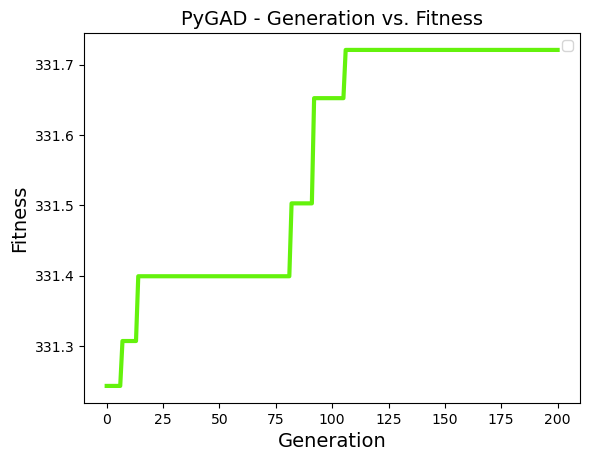

Best solution:  [2 4 1 2 5 5 3 1 3 0 5 6 1 0 1 3]
Best solution fitness:  331.72109603881836
best mindist:  31.72109603881836
[29.747333526611328, 26.396778106689453, 20.99604606628418, 27.845849990844727, 29.38714599609375, 29.92658042907715, 31.045719146728516, 30.075881958007812, 29.3103084564209, 30.84762191772461, 29.16770362854004, 28.911386489868164, 23.999784469604492, 29.692893981933594, 28.31488800048828, 29.389419555664062, 30.075157165527344, 30.18958854675293, 30.6082820892334, 29.80866813659668, 23.99985122680664, 30.35712432861328, 29.58163070678711, 30.00191879272461, 29.16986656188965, 30.173904418945312, 28.043752670288086, 29.888885498046875, 30.378376007080078, 27.559566497802734, 29.647024154663086, 29.772672653198242, 29.202495574951172, 30.139854431152344, 30.153900146484375, 30.004791259765625, 30.240467071533203, 29.91214370727539, 30.259645462036133, 30.86488914489746, 29.304283142089844, 27.674440383911133, 27.1859073638916, 29.37991714477539, 27.426467895507

In [8]:
population, population_mindists, population_dimensions = generator(8, 8)
print(population_mindists)
print(population_dimensions)

In [ ]:
print(max(population_mindists))
print(np.argmax(population_mindists))

168
30.745494842529297


In [9]:
population_dimensions = np.array(population_dimensions)
print("Number of individuals with dimension == 8: ", np.sum(population_dimensions == 8))
print("Number of individuals with dimension != 8: ", np.sum(population_dimensions != 8))

Number of individuals with dimension == 8:  268
Number of individuals with dimension != 8:  0


In [ ]:
# Example for how to get exact minimum distances of the population using Sage
from tqdm import tqdm

population_mindists_sage = []
for individual in tqdm(population):
    population_mindists_sage.append(SF.vertices2mindist(individual))

print(population_mindists_sage)
print(max(population_mindists_sage))
print(np.argmax(population_mindists_sage))

100%|██████████| 268/268 [26:53<00:00,  6.02s/it]

[28, 21, 21, 28, 28, 28, 28, 28, 21, 28, 28, 28, 24, 21, 28, 28, 28, 21, 28, 28, 24, 28, 28, 28, 28, 28, 21, 28, 28, 28, 21, 21, 28, 28, 30, 21, 28, 30, 28, 21, 28, 28, 24, 28, 28, 28, 28, 30, 28, 21, 28, 21, 28, 28, 28, 28, 32, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 21, 28, 28, 28, 28, 28, 28, 28, 30, 28, 28, 21, 28, 21, 28, 21, 28, 28, 21, 21, 28, 21, 28, 28, 28, 28, 28, 28, 21, 21, 28, 28, 28, 28, 30, 21, 21, 28, 28, 21, 28, 28, 21, 28, 28, 28, 28, 28, 28, 21, 28, 28, 28, 28, 28, 28, 28, 28, 21, 28, 21, 28, 28, 30, 28, 28, 21, 28, 28, 28, 21, 28, 21, 28, 21, 28, 28, 21, 28, 28, 28, 28, 21, 28, 28, 28, 28, 28, 28, 21, 28, 28, 28, 28, 28, 28, 30, 28, 28, 28, 28, 28, 28, 28, 21, 21, 21, 21, 28, 28, 28, 24, 24, 28, 28, 28, 24, 28, 21, 21, 28, 28, 21, 28, 28, 21, 28, 28, 30, 24, 28, 28, 24, 28, 21, 30, 21, 28, 28, 28, 28, 28, 28, 28, 28, 28, 21, 28, 28, 28, 21, 28, 28, 28, 28, 21, 28, 28, 21, 21, 28, 28, 28, 28, 28, 24, 21, 28, 28, 28, 21, 28, 28, 28, 28, 24, 21, 28, 28,